In [1]:
!pip install opencv-python-headless
!pip install path
!pip install pydicom
!pip install keras-tuner
!pip install scikeras
!pip install seaborn

     |████████████████████████████████| 48.3 MB 4.5 MB/s            
     |████████████████████████████████| 2.0 MB 5.5 MB/s            
     |████████████████████████████████| 135 kB 4.7 MB/s            
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 1.7.0
    Uninstalling importlib-metadata-1.7.0:
      Successfully uninstalled importlib-metadata-1.7.0
     |████████████████████████████████| 292 kB 27.2 MB/s            


In [2]:
! pip install -q kaggle

In [3]:
import warnings, random, os, pydicom, cv2, glob, re
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG19

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, MaxPooling2D, Conv2D, AveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from pydicom.pixel_data_handlers.util import apply_voi_lut

# tf.config.run_functions_eagerly(True)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c rsna-miccai-brain-tumor-radiogenomic-classification
! mkdir train
! unzip rsna-miccai-brain-tumor-radiogenomic-classification.zip -d train

100%|██████████████████████████████████████▉| 12.3G/12.3G [01:28<00:00, 187MB/s]
100%|███████████████████████████████████████| 12.3G/12.3G [01:28<00:00, 149MB/s]
Archive:  rsna-miccai-brain-tumor-radiogenomic-classification.zip
  inflating: train/sample_submission.csv  
  inflating: train/test/00001/FLAIR/Image-1.dcm  
  inflating: train/test/00001/FLAIR/Image-10.dcm  
  inflating: train/test/00001/FLAIR/Image-100.dcm  
  inflating: train/test/00001/FLAIR/Image-101.dcm  
  inflating: train/test/00001/FLAIR/Image-102.dcm  
  inflating: train/test/00001/FLAIR/Image-103.dcm  
  inflating: train/test/00001/FLAIR/Image-104.dcm  
  inflating: train/test/00001/FLAIR/Image-105.dcm  
  inflating: train/test/00001/FLAIR/Image-106.dcm  
  inflating: train/test/00001/FLAIR/Image-107.dcm  
  inflating: train/test/00001/FLAIR/Image-108.dcm  
  inflating: train/test/00001/FLAIR/Image-109.dcm  
  inflating: train/test/00001/FLAIR/Image-11.dcm  
  inflating: train/test/00001/FLAIR/Image-110.dcm  
  inf

In [ ]:
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64

## Exploración de datos

In [54]:
def load_dicom_image(path, img_size=SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = cv2.resize(data, (img_size, img_size))
    return data

array([[-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       ...,
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.]])

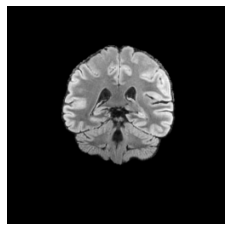

In [55]:
def plot_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    plt.imshow(data, cmap='gray')
    plt.axis('off')
    return data
plot_dicom_image('./train/train/00000/FLAIR/Image-154.dcm')

In [51]:
def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR"):
    files = sorted(glob.glob(f"./train/train/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)     
    return img3d

In [39]:
a = load_dicom_images_3d("00000")

In [42]:
load_dicom_image('./train/train/00000/FLAIR/Image-155.dcm')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [ ]:
df_labels = pd.read_csv('./train/train_labels.csv', dtype={0:'object', 1:'int8'})
df_labels.head()

In [ ]:
df_labels_train_val, df_labels_test = train_test_split(df_labels, test_size=0.2, random_state=123)
df_labels_train, df_labels_val = train_test_split(df_labels_train_val, test_size=0.2, random_state=123)

In [ ]:
def generator_train():
    for i in range(df_labels_train.shape[0]):
        x = load_dicom_images_3d(df_labels_train['BraTS21ID'].iloc[i])
        y = df_labels_train['MGMT_value'].iloc[i]
        yield x, y
def generator_val():
    for i in range(df_labels_val.shape[0]):
        x = load_dicom_images_3d(df_labels_val['BraTS21ID'].iloc[i])
        y = df_labels_val['MGMT_value'].iloc[i]
        yield x, y
def generator_test():
    for i in range(df_labels_test.shape[0]):
        x = load_dicom_images_3d(df_labels_test['BraTS21ID'].iloc[i])
        y = df_labels_test['MGMT_value'].iloc[i]
        yield x, y

In [ ]:
ds_train = tf.data.Dataset.from_generator(generator_train, args=[], 
                                          output_types=(tf.int16, tf.int8), 
                                          output_shapes = (((SIZE, SIZE, NUM_IMAGES), ())))
ds_val = tf.data.Dataset.from_generator(generator_val, args=[], 
                                          output_types=(tf.int16, tf.int8), 
                                          output_shapes = (((SIZE, SIZE, NUM_IMAGES), ())))
ds_test = tf.data.Dataset.from_generator(generator_test, args=[], 
                                          output_types=(tf.int16, tf.int8), 
                                          output_shapes = (((SIZE, SIZE, NUM_IMAGES), ())))
ds_train = ds_train.batch(8)
ds_val = ds_val.batch(8)
ds_test = ds_test.batch(8)

## Entrenamiento

In [ ]:
def crear_clasificador_propio(n_lay_convs = 3, fil1 = 16, fil2 = 32, fil3 = 64, ks=3, s=2, 
                              n_lay_dense = 2, nn1 = 32, nn2 = 16, activacion = 'relu'):
    output = 1
    filtros = [fil1, fil2, fil3]
    neurons = [nn1, nn2]
    clasificador = Sequential(name="ClasificadorPropio")
    clasificador.add(Input(shape=(SIZE, SIZE, NUM_IMAGES)))
    for i in range(n_lay_convs):
        clasificador.add(Conv2D(filters=filtros[i], kernel_size=ks, strides=s, padding="same", activation=activacion))
    clasificador.add(GlobalAveragePooling2D()) 
    for i in range(n_lay_dense):
        clasificador.add(Dense(neurons[i], activation=activacion))
    clasificador.add(Dense(output, activation='sigmoid', name= 'Capa_Salida'))
    clasificador.compile(loss='binary_crossentropy',
                          optimizer='adam', 
                          metrics=["accuracy"],
                          run_eagerly=True)
    return clasificador

In [ ]:
clasificador_propio = crear_clasificador_propio()
clasificador_propio.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)

In [ ]:
with tf.device('/device:GPU:0'): 
    clasificador_propio.fit(
        ds_train,
        validation_data=ds_val,
        epochs=10,
        callbacks=[early_stopping]
    )

47/47 [==============================] - 70s 1s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6920 - val_accuracy: 0.5745
Epoch 5/10
47/47 [==============================] - 70s 1s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6919 - val_accuracy: 0.5745
Epoch 6/10
47/47 [==============================] - 70s 1s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6917 - val_accuracy: 0.5745
Epoch 7/10
47/47 [==============================] - 70s 1s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6917 - val_accuracy: 0.5745
Epoch 8/10
47/47 [==============================] - 71s 2s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6915 - val_accuracy: 0.5745
Epoch 9/10
47/47 [==============================] - 70s 1s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6914 - val_accuracy: 0.5745
Epoch 10/10
47/47 [==============================] - 70s 1s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6913 - val_accuracy: 0.5745


In [ ]:
!mkdir models

In [ ]:
clasificador_propio.save('./models/clasificador_propio_base.h5')

In [ ]:
# 
clasificador_propio = tf.keras.models.load_model('./models/clasificador_propio_base.h5')

In [ ]:
def darF1Score(model, dataset, print_report=False):
    y_true, y_pred = [], []
    for x, y in dataset:
        y_true.extend(y.numpy().tolist())
        y_pred.extend(model.predict(x, verbose=0).round().astype(int).tolist())
    if print_report:
        print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='weighted')
    return y_true, y_pred, f1

In [ ]:
y_true, y_pred, f1 = darF1Score(clasificador_propio, ds_val, print_report=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.57      1.00      0.73        54

    accuracy                           0.57        94
   macro avg       0.29      0.50      0.36        94
weighted avg       0.33      0.57      0.42        94



In [ ]:
def get_params(params_grid):
    params = {}
    for key, list_values in params_grid.items():
        params[key] = random.choice(list_values)
    return params

In [26]:
def search_model(create_model, params_grid, ds_train, ds_val, n_iter=25):
    params_best_model, best_f1_score = None, 0
    for i in range(n_iter):
        params = get_params(params_grid)
        print('Training inter {} for params:\n'.format(i+1), params)
        model = create_model(**params)
        with tf.device('/device:GPU:0'): 
            model.fit(
                ds_train,
                validation_data=ds_val,
                epochs=25,
                callbacks=[early_stopping]
            )
        f1_score = darF1Score(model, ds_val)[2]
        print('F1-score for iter {}: {}'.format(i+1, f1_score))
        if f1_score > best_f1_score:
            params_best_model = params
            best_f1_score = f1_score
        print('Best F1-score so far:\n', best_f1_score)
        print('Best params so far:\n', params_best_model)
    return params_best_model, best_f1_score

In [27]:
params_grid = {  
    'n_lay_convs': [1, 2, 3],
    'fil1': [20, 16, 12],
    'fil2': [40, 32, 24],
    'fil3': [80, 64, 48],
    'ks': [3, 5, 7],
    's': [2, 3, 4],
    'n_lay_dense': [1, 2],
    'nn1': [120, 80, 40],
    'nn2': [40, 20, 16, 12],
    'activacion': ['relu','sigmoid']
}

params_best_model_propio, best_f1_score_propio = search_model(crear_clasificador_propio, params_grid, ds_train, ds_val)

Training inter 1 for params:
 {'n_lay_convs': 1, 'fil1': 16, 'fil2': 40, 'fil3': 80, 'ks': 5, 's': 4, 'n_lay_dense': 1, 'nn1': 80, 'nn2': 12, 'activacion': 'relu'}
Epoch 1/25
47/47 [==============================] - 69s 1s/step - loss: 0.6933 - accuracy: 0.4813 - val_loss: 0.6925 - val_accuracy: 0.5745
Epoch 2/25
47/47 [==============================] - 70s 1s/step - loss: 0.6932 - accuracy: 0.5080 - val_loss: 0.6921 - val_accuracy: 0.5745
Epoch 3/25
47/47 [==============================] - 71s 2s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6918 - val_accuracy: 0.5745
Epoch 4/25
47/47 [==============================] - 72s 2s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6917 - val_accuracy: 0.5745
Epoch 5/25
47/47 [==============================] - 72s 2s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6915 - val_accuracy: 0.5745
Epoch 6/25
47/47 [==============================] - 72s 2s/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6914 - val_accuracy: 0.5

KeyboardInterrupt: 

In [30]:
params_best_model_propio = {'n_lay_convs': 3, 'fil1': 16, 'fil2': 32, 'fil3': 80, 'ks': 5, 's': 2, 'n_lay_dense': 2, 'nn1': 40, 'nn2': 16, 'activacion': 'relu'}
#TODO: cambiar el diccionario anterior
best_clasificador_propio = crear_clasificador_propio(**params_best_model_propio)
best_clasificador_propio.summary()

Model: "ClasificadorPropio"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 128, 128, 16)      25616     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 32)        12832     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 80)        64080     
_________________________________________________________________
global_average_pooling2d_17  (None, 80)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_30 (Dense)             (None, 16)                656       
_________________________________________________________________
Capa_Salida (Dense)          (None, 1)          

In [35]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
with tf.device('/device:GPU:0'): 
    best_clasificador_propio.fit(
        ds_train.concatenate(ds_val),
        epochs=12,
        callbacks=[early_stopping]
    )

Epoch 1/12
59/59 [==============================] - 79s 1s/step - loss: 7.9570 - accuracy: 0.8120
Epoch 2/12
59/59 [==============================] - 70s 1s/step - loss: 0.2894 - accuracy: 0.8996
Epoch 3/12
59/59 [==============================] - 70s 1s/step - loss: 0.4034 - accuracy: 0.8868
Epoch 4/12
59/59 [==============================] - 70s 1s/step - loss: 0.2455 - accuracy: 0.9017
Epoch 5/12
59/59 [==============================] - 70s 1s/step - loss: 0.2519 - accuracy: 0.9038
Epoch 6/12
59/59 [==============================] - 71s 1s/step - loss: 0.2305 - accuracy: 0.8932
Epoch 7/12
59/59 [==============================] - 70s 1s/step - loss: 0.2176 - accuracy: 0.8889
Epoch 8/12
59/59 [==============================] - 71s 1s/step - loss: 0.2124 - accuracy: 0.8889
Epoch 9/12
59/59 [==============================] - 70s 1s/step - loss: 0.2086 - accuracy: 0.8974
Epoch 10/12
59/59 [==============================] - 70s 1s/step - loss: 0.2055 - accuracy: 0.8953
Epoch 11/12
59/59 [

In [36]:
best_clasificador_propio.save('./models/best_clasificador_propio.h5')

In [37]:
best_clasificador_propio = tf.keras.models.load_model('./models/best_clasificador_propio.h5')

## Evaluación

--------------------------------------------------------
Reporte para el mejor modelo propio sobre datos de entrenamiento
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       184
           1       0.98      0.89      0.93       190

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374

--------------------------------------------------------
Reporte para el mejor modelo propio sobre datos de validación
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        40
           1       1.00      0.91      0.95        54

    accuracy                           0.95        94
   macro avg       0.94      0.95      0.95        94
weighted avg       0.95      0.95      0.95        94

--------------------------------------------------------
Reporte para el mejor modelo propio sobre datos 

Text(54.260000000000005, 0.5, 'Etiquetas predichas')

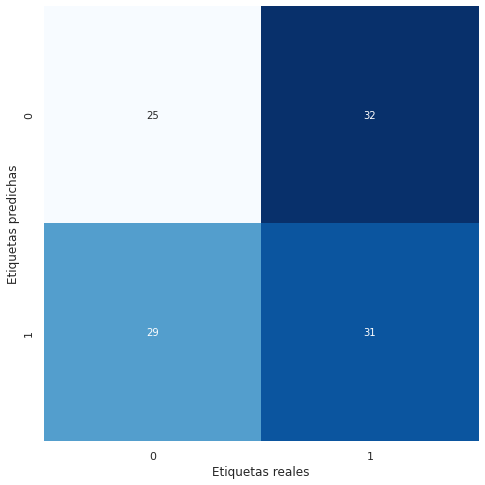

In [38]:
print('--------------------------------------------------------')
print('Reporte para el mejor modelo propio sobre datos de entrenamiento')
y_true, y_pred, f1 = darF1Score(best_clasificador_propio, ds_train, print_report=True)
print('--------------------------------------------------------')
print('Reporte para el mejor modelo propio sobre datos de validación')
y_true, y_pred, f1 = darF1Score(best_clasificador_propio, ds_val, print_report=True)
print('--------------------------------------------------------')
print('Reporte para el mejor modelo propio sobre datos de prueba')
y_true, y_pred, f1 = darF1Score(best_clasificador_propio, ds_test, print_report=True)
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')